In [3]:
################################################################
####### IMPORTATION DES MODULES ################################
################################################################

# Set up
import sys
import os

#project_root = os.path.abspath(os.path.join(os.getcwd(), '.'))
#if project_root not in sys.path:
    #sys.path.append(project_root)

import pathlib
project_root = pathlib.Path().resolve().parent    
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Importation des modules nécessaires
import pandas as pd
import keras
from sklearn.preprocessing import StandardScaler

# Gestionnaire de données
from data.DataManager import DataManager

# Modèles de Deep Learning
from dl_models.MLPs import create_mlp_model,  LRHistory
from dl_models.CNNs import create_cnn_model
from dl_models.RNNs import LSTM, GRU, TKAN, create_rnn_model

# Métriques
from utils.metrics import compile_models_metrics, compute_estimators_metrics
from utils.visualization_tools import plot_model_metrics

#Méthodes de visualisation
from utils.visualization_tools import evaluate_and_plot

###################################################
####### VARIABLES DE BASE ET CALLBACKS ############
###################################################

keras.utils.set_random_seed(72)

# Nombre d'itération / taille de batch
N_MAX_EPOCH = 100
BATCH_SIZE = 32

# Liste de callbacks à utiliser dans les modèles
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience = 5,
        restore_best_weights=True
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.05,
        patience = 5,
        min_delta = 1e-6,
        verbose = 0
    ),

    LRHistory()
]

################################################################
####### CONSTRUCTION DES DONNEES (FEATURES ET LABEL) ###########
################################################################

# Paramètres

# Définition des périodes de récupération
train_period: list = [(2023,7), (2023,8), (2023, 9), (2023,10)]
test_period: list = [(2023,11)]

# Choix lié à l'utilisation des indicateurs de dépendance sérielle
use_serial_dependance: bool = False

# Définition des actifs à récupérer
#cryptos_train: list = ["ETHUSDT", "BNBUSDT", "XRPUSDT", "SOLUSDT", "ADAUSDT", "DOTUSDT"]
#cryptos_test: list = ["MATICUSDT", "TRXUSDT"]

cryptos_train: list = ["BNBUSDT", "XRPUSDT", "SOLUSDT", "ADAUSDT", "DOTUSDT"]
cryptos_test: list = ["MATICUSDT", "TRXUSDT"]


# Création du datamanager pour gérer les données d'entrainement + import
manager_train: DataManager = DataManager(symbols=cryptos_train, dates=train_period, light=True)
manager_train.download_and_prepare_data()

# Construction des features / labels pour les données d'entrainement
feature_paths = manager_train.load_features(use_serial_dependance)
labels_paths = manager_train.build_labels()

# Création du datamanager pour gérer les données de test (et import)
manager_test: DataManager = DataManager(symbols=cryptos_test, dates=test_period, light=True)
manager_test.download_and_prepare_data()

# Construction des features et labels pour les données de test
feature_paths_test = manager_test.load_features(use_serial_dependance)
labels_paths_test = manager_test.build_labels()


# Test dataframe de construction de test et val
X_train, X_val, y_train, y_val = manager_train.build_train_val_dataset()


# Construction des tests
X_test, y_test = manager_test.build_train_val_dataset(is_test=True)

# Normalisation des features
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Normalisation des features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test).reshape(X_test.shape)

# Train CNN
X_tr_cnn, y_tr_cnn = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='cnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TRAIN CNN :", X_tr_cnn.shape, y_tr_cnn.shape)

# Création et entraînement du CNN
input_shape = X_tr_cnn.shape[1:]     # (1440, 11)
cnn = create_cnn_model(input_shape=input_shape, model_type="simple")
cnn.compile(optimizer='adam', loss='mse')

history = cnn.fit(
    X_tr_cnn, y_tr_cnn,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=5,
                                             restore_best_weights=True)]
)


# Construction des features de test au bon format (ici CNN minute-level)
X_te_cnn, y_te_cnn = manager_test.format_data(
    X_test_scaled,
    y_test_scaled,
    model_type='cnn',   
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST CNN :", X_te_cnn.shape, y_te_cnn.shape)

evaluate_and_plot(
    model    = cnn,        
    X        = X_te_cnn,
    y        = y_te_cnn,
    scaler_y = scaler_y,  
    title    = "CNN simple – actifs de test"
)


Téléchargement Klines : https://data.binance.vision/data/futures/um/monthly/klines/BNBUSDT/1m/BNBUSDT-1m-2023-07.zip
Klines sauvegardé : C:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\BNBUSDT-1m-2023-07.parquet
Téléchargement BookTicker : https://data.binance.vision/data/futures/um/monthly/bookTicker/BNBUSDT/BNBUSDT-bookTicker-2023-07.zip
BookTicker sauvegardé : C:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\BNBUSDT-bookTicker-2023-07.parquet
Téléchargement Klines : https://data.binance.vision/data/futures/um/monthly/klines/BNBUSDT/1m/BNBUSDT-1m-2023-08.zip
Klines sauvegardé : C:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\BNBUSDT-1m-2023-08.parquet
Téléchargement BookTicker : https://data.binance.vision/data/futures/um/monthly/bookTicker/BNBUSDT/BNBUSDT-bookTicker-2023-08.zip
BookTicker sauvegardé : C:\Users\theod\OneDrive\Documents\GitHub\Deep-Learnin

ValueError: Length mismatch: Expected axis has 7 elements, new values have 3 elements

## IMPORTATION DES MODULES

In [1]:

# Set up
import sys
import os

#project_root = os.path.abspath(os.path.join(os.getcwd(), '.'))
#if project_root not in sys.path:
    #sys.path.append(project_root)

import pathlib
project_root = pathlib.Path().resolve().parent    
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Importation des modules nécessaires
import pandas as pd
import keras
from sklearn.preprocessing import StandardScaler

# Gestionnaire de données
from data.DataManager import DataManager

# Modèles de Deep Learning
from dl_models.MLPs import create_mlp_model,  LRHistory
from dl_models.CNNs import create_cnn_model
from dl_models.RNNs import LSTM, GRU, TKAN, create_rnn_model

# Métriques
from utils.metrics import compile_models_metrics, compute_estimators_metrics
from utils.visualization_tools import plot_model_metrics

#Méthodes de visualisation
from utils.visualization_tools import evaluate_and_plot


## VARIABLES DE BASE ET CALLBACKS 




In [2]:
keras.utils.set_random_seed(72)

# Nombre d'itération / taille de batch
N_MAX_EPOCH = 100
BATCH_SIZE = 32

# Liste de callbacks à utiliser dans les modèles
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience = 5,
        restore_best_weights=True
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.05,
        patience = 5,
        min_delta = 1e-6,
        verbose = 0
    ),

    LRHistory()
]

## CONSTRUCTION DES DONNEES (FEATURES ET LABEL) 

In [ ]:
# Paramètres

# Définition des périodes de récupération
train_period: list = [(2023,7), (2023,8), (2023, 9), (2023,10)]
test_period: list = [(2023,11)]

# Choix lié à l'utilisation des indicateurs de dépendance sérielle
use_serial_dependance: bool = False

# Définition des actifs à récupérer
cryptos_train: list = ["ETHUSDT", "BNBUSDT", "XRPUSDT", "SOLUSDT", "ADAUSDT", "DOTUSDT"]
cryptos_test: list = ["MATICUSDT", "TRXUSDT"]




# Création du datamanager pour gérer les données d'entrainement + import
manager_train: DataManager = DataManager(symbols=cryptos_train, dates=train_period, light=True)
manager_train.download_and_prepare_data()

# Construction des features / labels pour les données d'entrainement
feature_paths = manager_train.load_features(use_serial_dependance)
labels_paths = manager_train.build_labels()

# Création du datamanager pour gérer les données de test (et import)
manager_test: DataManager = DataManager(symbols=cryptos_test, dates=test_period, light=True)
manager_test.download_and_prepare_data()

# Construction des features et labels pour les données de test
feature_paths_test = manager_test.load_features(use_serial_dependance)
labels_paths_test = manager_test.build_labels()


# Test dataframe de construction de test et val
X_train, X_val, y_train, y_val = manager_train.build_train_val_dataset()


# Construction des tests
X_test, y_test = manager_test.build_train_val_dataset(is_test=True)

# Normalisation des features
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Normalisation des features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test).reshape(X_test.shape)


Klines déjà existant : C:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-07.parquet
Téléchargement BookTicker : https://data.binance.vision/data/futures/um/monthly/bookTicker/ETHUSDT/ETHUSDT-bookTicker-2023-07.zip
BookTicker sauvegardé : C:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-07.parquet
Téléchargement Klines : https://data.binance.vision/data/futures/um/monthly/klines/ETHUSDT/1m/ETHUSDT-1m-2023-08.zip
Klines sauvegardé : C:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-08.parquet
Téléchargement BookTicker : https://data.binance.vision/data/futures/um/monthly/bookTicker/ETHUSDT/ETHUSDT-bookTicker-2023-08.zip
BookTicker sauvegardé : C:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-08.parquet
Téléchargement Klines : https://data.bin

## MLP

TRAIN MLP : (384, 21600) (384, 1)
Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.5061 - val_loss: 0.7770 - learning_rate: 0.0010
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2902 - val_loss: 0.7770 - learning_rate: 0.0010
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2902 - val_loss: 0.7770 - learning_rate: 0.0010
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2902 - val_loss: 0.7770 - learning_rate: 0.0010
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2902 - val_loss: 0.7770 - learning_rate: 0.0010
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2902 - val_loss: 0.7770 - learning_rate: 0.0010
TEST  MLP : (30, 21600) (30, 1)
MLP simple - actifs de test – Test set  |  RMSE = 0.0001   MAE = 0.0000   R² = -0.3878


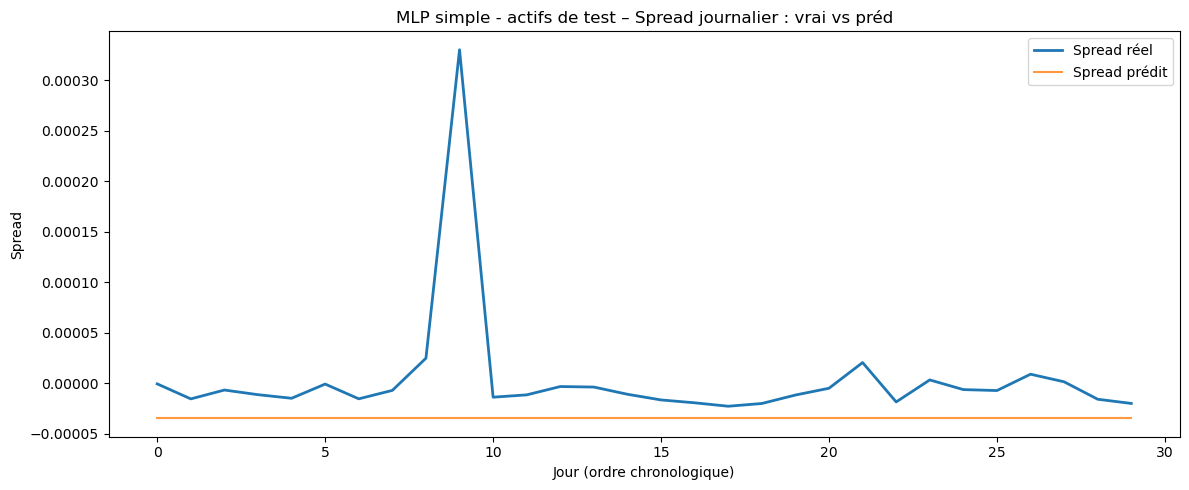

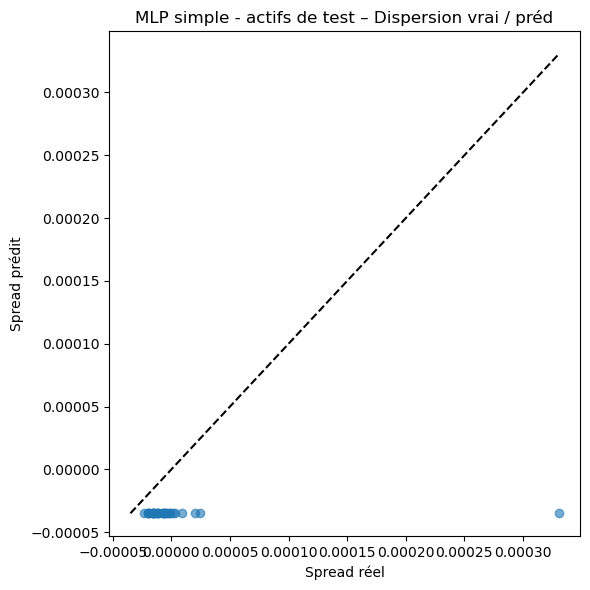

In [ ]:
# Mise en forme des données pour le MLP
X_tr_mlp, y_tr_mlp = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='mlp',         
    daily=False,              
    nb_assets=1,              
    minutes_per_day=1440
)
print("TRAIN MLP :", X_tr_mlp.shape, y_tr_mlp.shape)


# Construction et entraînement du modèle MLP         
input_shape = X_tr_mlp.shape         
mlp = create_mlp_model(
    input_shape=input_shape,          
    model_type="simple",             
    hidden_dims=[128, 64, 32]         
)
mlp.compile(optimizer='adam', loss='mse')

history_mlp = mlp.fit(
    X_tr_mlp, y_tr_mlp,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1,
    callbacks=callbacks              
)

#Préparation du set de test au même format
X_te_mlp, y_te_mlp = manager_test.format_data(
    X_test_scaled, y_test_scaled,
    model_type='mlp',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST  MLP :", X_te_mlp.shape, y_te_mlp.shape)


#Évaluation + visualisation
evaluate_and_plot(
    model    = mlp,
    X        = X_te_mlp,
    y        = y_te_mlp,
    scaler_y = scaler_y,            
    title    = "MLP simple - actifs de test",
    history=history_mlp
)

## CNN

TRAIN CNN : (384, 1440, 15) (384, 1)
Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 2.3197 - val_loss: 0.7770
Epoch 2/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.2902 - val_loss: 0.7770
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2902 - val_loss: 0.7770
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.2902 - val_loss: 0.7770
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2902 - val_loss: 0.7770
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2902 - val_loss: 0.7770
TEST CNN : (30, 1440, 15) (30, 1)
CNN simple - actifs de test – Test set  |  RMSE = 0.0001   MAE = 0.0000   R² = -0.3878


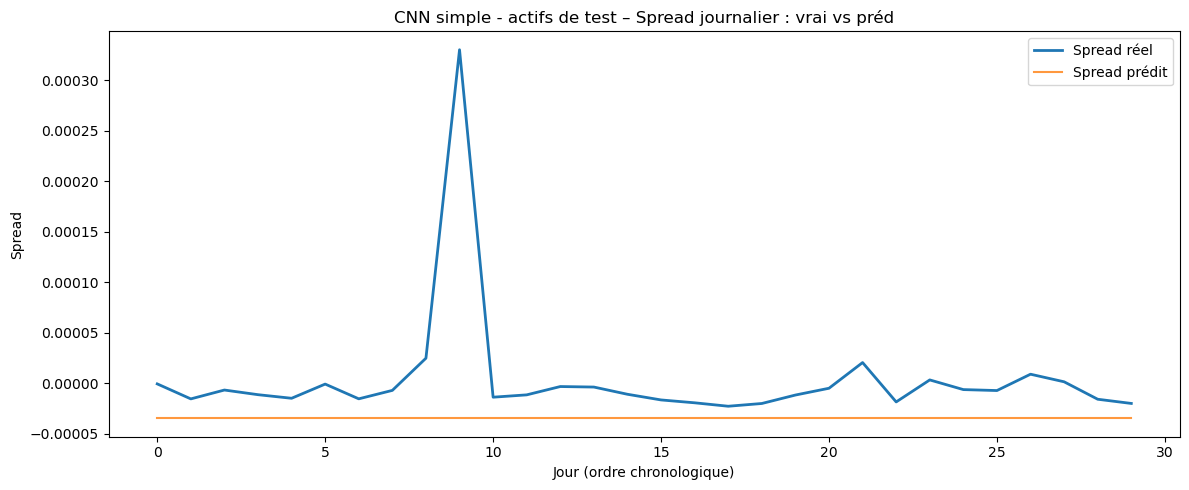

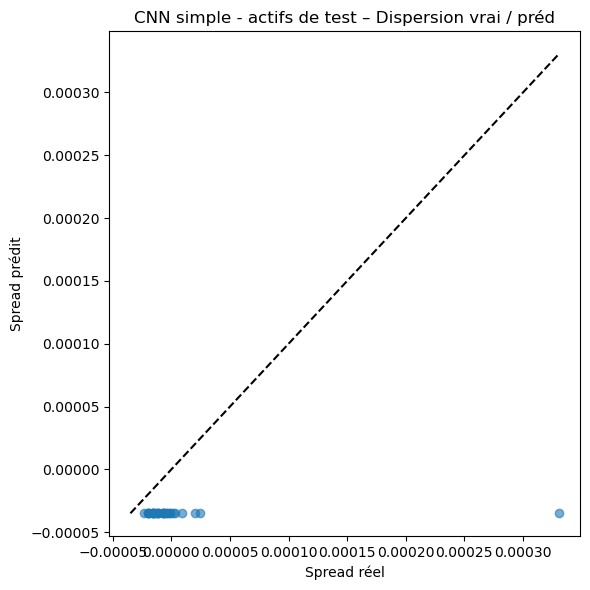

In [ ]:
# Train CNN
X_tr_cnn, y_tr_cnn = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='cnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TRAIN CNN :", X_tr_cnn.shape, y_tr_cnn.shape)

# Création et entraînement du CNN
input_shape = X_tr_cnn.shape[1:]    
cnn = create_cnn_model(input_shape=input_shape, model_type="simple")
cnn.compile(optimizer='adam', loss='mse')

history = cnn.fit(
    X_tr_cnn, y_tr_cnn,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=5,
                                             restore_best_weights=True)]
)


# Construction des features de test au bon format (ici CNN minute-level)
X_te_cnn, y_te_cnn = manager_test.format_data(
    X_test_scaled,
    y_test_scaled,
    model_type='cnn',   
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST CNN :", X_te_cnn.shape, y_te_cnn.shape)

evaluate_and_plot(
    model    = cnn,        
    X        = X_te_cnn,
    y        = y_te_cnn,
    scaler_y = scaler_y,  
    title    = "CNN simple - actifs de test",
    history=history
)

## LSTM

In [ ]:
### Mise en forme des données pour un RNN (LSTM)        ###
X_tr_rnn, y_tr_rnn = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='rnn',          # ← reshape (nb_days, 1440, n_feat)
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TRAIN RNN :", X_tr_rnn.shape, y_tr_rnn.shape)


# Construction & fit du modèle RNN 
input_shape = X_tr_rnn.shape[1:]        # (1440, n_feat)
rnn = create_rnn_model(
    input_shape=input_shape,
    nb_assets=1,                         # 1 valeur de spread par séquence
    rnn_layer=LSTM(units=100, return_sequences=False, dropout=0.2),
    use_conv=False                      
)
rnn.compile(optimizer='adam', loss='mse')

history_rnn = rnn.fit(
    X_tr_rnn, y_tr_rnn,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1,
    callbacks=callbacks                 # même liste que pour le CNN/MLP
)


#Préparation du set de test au même format 
X_te_rnn, y_te_rnn = manager_test.format_data(
    X_test_scaled, y_test_scaled,
    model_type='rnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST  RNN :", X_te_rnn.shape, y_te_rnn.shape)


## Évaluation + visualisation  
evaluate_and_plot(
    model    = rnn,
    X        = X_te_rnn,
    y        = y_te_rnn,
    scaler_y = scaler_y,                 # pour dé-normaliser le spread
    title    = "LSTM – actifs de test",
    history=history_rnn
)


## GRU

In [ ]:

# Mise en forme des données pour le GRU (identique RNN) 
X_tr_gru, y_tr_gru = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='rnn',          # reshape (nb_days, 1440, n_feat)
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TRAIN GRU :", X_tr_gru.shape, y_tr_gru.shape)


##Construction & entraînement du modèle GRU  
from dl_models.RNNs import GRU, create_rnn_model

input_shape = X_tr_gru.shape[1:]            # (1440, n_feat)
gru = create_rnn_model(
    input_shape=input_shape,
    nb_assets=1,                             # 1 spread/jour à prédire
    rnn_layer=GRU(units=100,
                  return_sequences=False,
                  dropout=0.3),
    use_conv=False                           
)
gru.compile(optimizer='adam', loss='mse')

history_gru = gru.fit(
    X_tr_gru, y_tr_gru,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1,
    callbacks=callbacks                     
)


#Préparation du jeu de test 
X_te_gru, y_te_gru = manager_test.format_data(
    X_test_scaled, y_test_scaled,
    model_type='rnn',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440
)
print("TEST  GRU :", X_te_gru.shape, y_te_gru.shape)


#Évaluation + visualisation   
from utils.visualization_tools import evaluate_and_plot

evaluate_and_plot(
    model    = gru,
    X        = X_te_gru,
    y        = y_te_gru,
    scaler_y = scaler_y,                     
    title    = "GRU - actifs de test",
    history=history_gru
)


## TKAN

In [ ]:

## Mise en forme des données pour le TKAN (séquences) 
# longueur de fenêtre temporelle (nb de jours consécutifs)
WINDOW = 5          #????

X_tr_tkan, y_tr_tkan = manager_train.format_data(
    X_train_scaled, y_train_scaled,
    model_type='seq',           # indique qu’on veut des fenêtres glissantes
    daily=False,
    nb_assets=1,
    minutes_per_day=1440,
    window=WINDOW
)
print("TRAIN TKAN :", X_tr_tkan.shape, y_tr_tkan.shape)



# Construction & fit du modèle TKAN                 
input_shape = X_tr_tkan.shape[1:]        # (WINDOW, 1440 * n_feat)
tkan = create_rnn_model(
    input_shape=input_shape,
    nb_assets=1,                          # 1 spread / fenêtre
    rnn_layer=TKAN(units=100,
                   num_heads=4,
                   return_sequences=False),
    use_conv=False                        # pré-CNN inutile ici
)
tkan.compile(optimizer='adam', loss='mse')

history_tkan = tkan.fit(
    X_tr_tkan, y_tr_tkan,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    verbose=1,
    callbacks=callbacks                   # early-stopping, LR scheduler, etc.
)


# Préparation du jeu de test (même fenêtre) 
X_te_tkan, y_te_tkan = manager_test.format_data(
    X_test_scaled, y_test_scaled,
    model_type='seq',
    daily=False,
    nb_assets=1,
    minutes_per_day=1440,
    window=WINDOW
)
print("TEST  TKAN :", X_te_tkan.shape, y_te_tkan.shape)


# Évaluation + visualisation  
evaluate_and_plot(
    model    = tkan,
    X        = X_te_tkan,
    y        = y_te_tkan,
    scaler_y = scaler_y,
    title    = f"TKAN (window {WINDOW}) - actifs de test",
    history=history_tkan
)
